In [1]:
import acquire
import outliers
import prep
import pandas as pd
import numpy as np
import math
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from sklearn import metrics

from scipy.stats import entropy

import matplotlib.dates as mdates

## Questions To Answer
- Which lesson appears to attract the most traffic consistently across cohorts (per program)?
- Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over? 
- Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 
- Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents? 
- At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before? 
- What topics are grads continuing to reference after graduation and into their jobs (for each program)? 
- Which lessons are least accessed? 
- Anything else I should be aware of? 

In [2]:
# prep data using imported function from .py file
df = prep.prep_curriculum_data()

In [3]:
df

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
2018-01-26 09:56:02,java-ii,1.0,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,971051961.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1.0,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,971051961.0
2018-01-26 09:56:06,slides/object_oriented_programming,1.0,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,971051961.0
2018-01-26 10:40:15,javascript-i/functions,1.0,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,971051961.0
2018-01-26 11:26:13,java-i,1.0,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,971051961.0
...,...,...,...,...,...,...,...,...,...
NaT,NaN,NaN,10.0,NaN,Balboa,2015-11-03,2016-03-11,4.0,NaN
NaT,NaN,NaN,20.0,NaN,Redwood,2017-07-31,2017-12-06,2.0,NaN
NaT,NaN,NaN,30.0,NaN,Ada,2019-02-04,2019-06-16,3.0,NaN
NaT,NaN,NaN,60.0,NaN,Io,2020-07-20,2021-01-21,2.0,NaN


In [4]:
df.isnull().sum()

page_viewed    7
user_id        6
cohort_id      0
ip             6
name           0
start_date     0
end_date       0
program_id     0
conv_ip        6
dtype: int64

In [5]:
## Very few nulls, dropping the rest
df = df.dropna()

In [6]:
df.index.name = 'datetime'

In [7]:
## removing the scientific notation formating
pd.options.display.float_format = '{:.1f}'.format
ip_outliers = outliers.emp_rule(df.conv_ip, 3)
ip_outliers.x.value_counts()

192171117210.0    8062
173173115201.0    1157
173174211206.0     945
170248173245.0     855
170248173247.0     822
                  ... 
199116118166.0       1
173174147198.0       1
173239232157.0       1
173127108144.0       1
192241235228.0       1
Name: x, Length: 365, dtype: int64

In [8]:
user_outliers = outliers.emp_rule(df.user_id, 2)
user_outliers.x.value_counts()

Series([], Name: x, dtype: int64)

### Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [9]:
#removing limitations
pd.options.display.max_columns = None
pd.options.display.max_rows = None

Text(0.5, 1.0, 'Subject Accessed The Most By Web Dev Students')

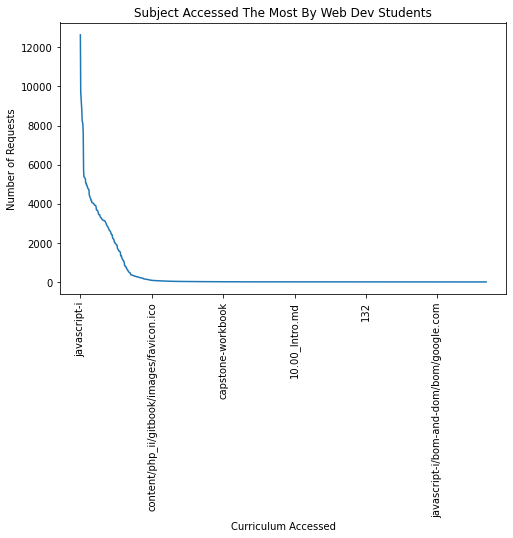

In [10]:
plt.figure(figsize=(8,5))
wd = df[df.program_id != 3]
wd = wd[wd.name != 'Staff']
wd = wd[wd.name != 'Unknown']
wd.page_viewed.value_counts().plot()
plt.xticks(rotation=90)
plt.ylabel('Number of Requests')
plt.xlabel('Curriculum Accessed')
plt.title('Subject Accessed The Most By Web Dev Students')

Text(0.5, 1.0, 'Subject Accessed The Most By Data Science Students')

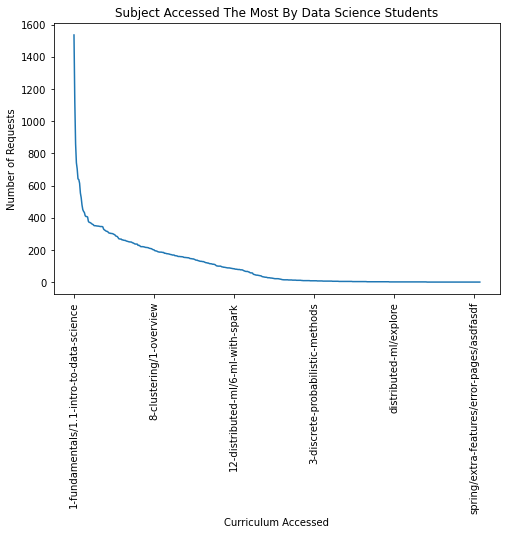

In [11]:
plt.figure(figsize=(8,5))
ds = df[df.program_id == 3]
ds.page_viewed.value_counts().plot()
plt.xticks(rotation=90)
plt.ylabel('Number of Requests')
plt.xlabel('Curriculum Accessed')
plt.title('Subject Accessed The Most By Data Science Students')

## Conclusion
- Web Dev Students access the Javascript I portion of the curriculum the most.
- Data Science students access Intro to Data science the most.

### When were the programs accessing these curriculum subjects?

Text(0, 0.5, 'Number of Requests')

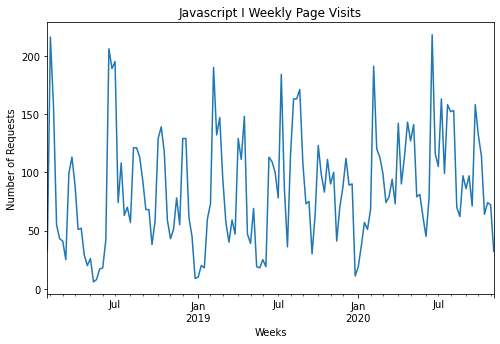

In [12]:
plt.figure(figsize=(8,5))
wd[wd.page_viewed == 'javascript-i'].page_viewed.resample('w').count().plot()
plt.title('Javascript I Weekly Page Visits')
plt.xlabel('Weeks')
plt.ylabel('Number of Requests')

Text(0, 0.5, 'Number of Requests')

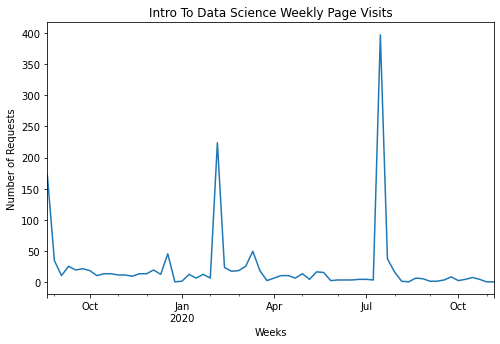

In [13]:
plt.figure(figsize=(8,5))
ds[ds.page_viewed == '1-fundamentals/1.1-intro-to-data-science'].page_viewed.resample('w').count().plot()
plt.title('Intro To Data Science Weekly Page Visits')
plt.xlabel('Weeks')
plt.ylabel('Number of Requests')

### Conclusions
- Web Dev students appear to have been constantly referring back to the Javascript I material
- Data Scientist accessed the Intro to Data Science lesson in bulk and a lot more often for a short period of time.

### Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

In [14]:
wd.groupby(by = wd.name).page_viewed.value_counts().nlargest(10)

name       page_viewed 
Ceres      javascript-i    977
Hyperion   javascript-i    884
Voyageurs  javascript-i    884
Lassen     index.html      877
Zion       javascript-i    868
Voyageurs  java-iii        770
Fortuna    java-iii        767
           javascript-i    756
Voyageurs  java-ii         754
Ceres      html-css        753
Name: page_viewed, dtype: int64

In [15]:
ds.groupby(by = ds.name).page_viewed.value_counts().nlargest(10)

name    page_viewed                             
Darden  classification/overview                     759
Bayes   1-fundamentals/1.1-intro-to-data-science    615
Curie   6-regression/1-overview                     595
Darden  classification/scale_features_or_not.svg    590
Bayes   6-regression/1-overview                     521
Darden  sql/mysql-overview                          513
Curie   1-fundamentals/1.1-intro-to-data-science    461
Darden  1-fundamentals/1.1-intro-to-data-science    460
Curie   3-sql/1-mysql-overview                      441
Bayes   10-anomaly-detection/1-overview             383
Name: page_viewed, dtype: int64

### Conclusions

Web Dev:

- Ceres spent a significant amount of time on index.html compared to other cohorts.
- It appears the vast majority spent their time on Java related subjects.


Data Science:

- Darden accessed the Classification Overview lesson significantly the most.
- Curies spent more time on the SQL Overview than other cohorts.

### Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [16]:
# Creating a dataframe that only consists of the active cohorts
active_students = df[(df.name == 'Jupiter') | (df.name == 'Bash') | (df.name == 'Darden') | (df.name == 'Hyperion')| (df.name == 'Io')]

In [17]:
active_students.head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-05-26 17:04:28,html-css,655.0,58.0,107.128.2.166,Hyperion,2020-05-26,2020-11-10,2.0,1071282166.0
2020-05-27 00:31:35,html-css,655.0,58.0,162.194.247.205,Hyperion,2020-05-26,2020-11-10,2.0,162194247205.0
2020-05-27 00:32:50,html-css/introduction,655.0,58.0,162.194.247.205,Hyperion,2020-05-26,2020-11-10,2.0,162194247205.0
2020-05-27 00:46:52,html-css,655.0,58.0,162.194.247.205,Hyperion,2020-05-26,2020-11-10,2.0,162194247205.0
2020-05-27 00:47:03,javascript-i,655.0,58.0,162.194.247.205,Hyperion,2020-05-26,2020-11-10,2.0,162194247205.0


In [18]:
active_students.user_id.value_counts().tail(20)

676.0    164
775.0    162
767.0    153
756.0    153
765.0    148
762.0    141
704.0    120
758.0    117
683.0    102
766.0    100
781.0     79
734.0     78
702.0     76
784.0     65
783.0     50
780.0     41
785.0     28
772.0     24
697.0      7
679.0      4
Name: user_id, dtype: int64

In [19]:
## Creating a dataframe with the least active user's
barely_active = df[(df.user_id == 679.0)|(df.user_id == 697.0)|(df.user_id == 772.0)|(df.user_id == 785.0)|(df.user_id == 780.0)|(df.user_id == 783.0)]

In [20]:
barely_active.head(20)

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679.0,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,2428146155.0
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679.0,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,2428146155.0
2020-07-13 15:20:48,3-sql/1-mysql-overview,697.0,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,136507027.0
2020-07-13 15:20:50,1-fundamentals/1.1-intro-to-data-science,697.0,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,136507027.0
2020-07-13 15:20:59,1-fundamentals/1.2-data-science-pipeline,697.0,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,136507027.0
2020-07-13 15:21:01,1-fundamentals/1.1-intro-to-data-science,697.0,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,136507027.0
2020-07-13 15:21:12,2-storytelling/3-tableau,697.0,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,136507027.0
2020-07-13 15:21:16,2-storytelling/3.3-creating-charts,697.0,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,136507027.0
2020-07-13 15:26:39,4-python/8.4.1-pandas-overview,697.0,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,136507027.0


Text(0, 0.5, 'Number of Requests')

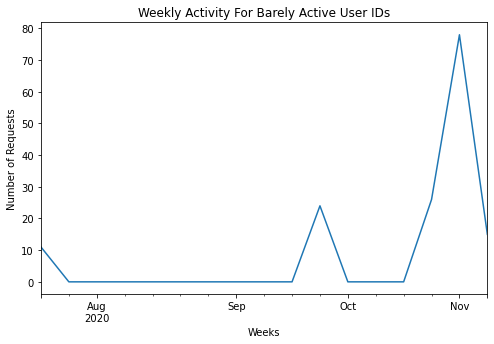

In [21]:
plt.figure(figsize=(8,5))
barely_active.page_viewed.resample('w').count().plot()
plt.title('Weekly Activity For Barely Active User IDs')
plt.xlabel('Weeks')
plt.ylabel('Number of Requests')

In [22]:
# Checking for multiple user id's with the same ip
df[df.ip == '136.50.70.27'].user_id.value_counts()

699.0    1015
697.0       7
Name: user_id, dtype: int64

In [23]:
df[df.ip == '99.132.128.255'].user_id.value_counts()

687.0    536
780.0     41
Name: user_id, dtype: int64

### Conclusions

- Web Dev and Data Science Cohorts both had roughly the same trend as to student inactivity.
- The lowest activity on the curriculum came out of both Darden and Jupiter which are the most recent classes at CodeUp.
- The major similarity between the two cohorts and lack of activity is that both cohorts were full time at home.
- Zoom appears to have had a major impact on the activity to the curriculum from past cohorts, since the instructors have the ability to screen share the curriculum.
- It appears students are just referring to the curriculum to read and study, rather than follow along in class as it was before.
- One big factor is it appears that there is a new user id generated for every device a student accesses the curriculum.
- Shown above, a student will appear to be not interacting but they are actually more active with another user id.

### Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents?

In [24]:
#Create a dataframe with all the untracked users and ips
sus_users = df[df.name == 'Unknown']
sus_users.head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2018-01-26 16:46:24,spring/extra-features/form-validation,48.0,0.0,97.105.19.61,Unknown,2000-01-01,3000-01-01,0.0,971051961.0
2018-01-26 18:32:17,mysql/relationships/joins,48.0,0.0,97.105.19.61,Unknown,2000-01-01,3000-01-01,0.0,971051961.0
2018-01-26 18:32:33,mysql/tables,48.0,0.0,97.105.19.61,Unknown,2000-01-01,3000-01-01,0.0,971051961.0
2018-01-26 18:32:37,mysql/databases,48.0,0.0,97.105.19.61,Unknown,2000-01-01,3000-01-01,0.0,971051961.0
2018-01-26 18:32:43,mysql/relationships,48.0,0.0,97.105.19.61,Unknown,2000-01-01,3000-01-01,0.0,971051961.0


In [25]:
sus_users.ip.value_counts()

97.105.19.58       13242
70.117.16.60        1312
70.94.165.107       1150
23.116.170.48       1101
67.11.117.74        1055
97.105.19.61        1022
70.121.134.234       918
66.69.62.219         869
173.173.113.51       714
69.58.159.196        712
136.50.11.90         669
76.185.211.152       661
66.25.163.198        626
70.123.200.67        580
104.182.13.78        531
70.123.200.120       530
24.243.64.3          482
23.127.174.233       471
45.23.250.16         459
72.181.105.81        422
24.26.242.9          418
72.177.182.225       402
99.151.201.126       383
67.11.134.242        374
136.50.57.27         346
216.177.189.26       340
192.171.117.210      307
66.69.98.11          289
70.120.8.59          286
72.181.113.170       285
68.201.219.223       284
64.148.245.30        265
70.117.6.133         232
24.251.143.169       217
68.2.202.8           178
136.50.22.105        172
173.173.127.101      149
70.120.3.141         144
70.120.16.42         140
156.80.4.2           139


In [26]:
df[df.ip == '97.105.19.58'].user_id.value_counts()

11.0     5120
64.0     4692
53.0     4581
314.0    3259
315.0    2471
344.0    2469
1.0      2401
211.0    2389
248.0    1828
277.0    1823
418.0    1809
428.0    1785
423.0    1598
531.0    1583
363.0    1582
323.0    1527
325.0    1525
354.0    1486
458.0    1458
524.0    1454
304.0    1421
234.0    1415
407.0    1405
433.0    1387
410.0    1382
479.0    1375
416.0    1342
270.0    1341
507.0    1308
490.0    1299
272.0    1291
440.0    1277
475.0    1259
334.0    1246
438.0    1217
386.0    1203
269.0    1201
324.0    1195
393.0    1189
439.0    1185
491.0    1184
446.0    1170
511.0    1166
328.0    1156
436.0    1132
408.0    1130
368.0    1130
412.0    1127
476.0    1113
437.0    1107
453.0    1085
302.0    1082
494.0    1082
489.0    1076
404.0    1062
273.0    1051
337.0    1047
275.0    1039
347.0    1031
330.0    1022
264.0    1009
355.0     997
263.0     989
387.0     987
452.0     984
414.0     977
501.0     973
349.0     960
215.0     958
413.0     954
495.0     953
375.0 

In [27]:
df[df.ip == '70.117.16.60'].user_id.value_counts()

716.0    1312
Name: user_id, dtype: int64

In [28]:
df[df.ip == '70.117.16.60'].head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-07-20 16:16:34,html-css,716.0,0.0,70.117.16.60,Unknown,2000-01-01,3000-01-01,0.0,701171660.0
2020-07-20 16:16:41,javascript-i,716.0,0.0,70.117.16.60,Unknown,2000-01-01,3000-01-01,0.0,701171660.0
2020-07-20 17:22:33,html-css,716.0,0.0,70.117.16.60,Unknown,2000-01-01,3000-01-01,0.0,701171660.0
2020-07-20 17:22:42,html-css/introduction,716.0,0.0,70.117.16.60,Unknown,2000-01-01,3000-01-01,0.0,701171660.0
2020-07-20 17:22:43,html-css/elements,716.0,0.0,70.117.16.60,Unknown,2000-01-01,3000-01-01,0.0,701171660.0


In [29]:
df[df.ip == '70.94.165.107'].user_id.value_counts()

727.0    1150
Name: user_id, dtype: int64

In [30]:
df[df.ip == '70.94.165.107'].head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-07-21 09:23:25,html-css,727.0,0.0,70.94.165.107,Unknown,2000-01-01,3000-01-01,0.0,7094165107.0
2020-07-21 09:37:29,html-css/introduction,727.0,0.0,70.94.165.107,Unknown,2000-01-01,3000-01-01,0.0,7094165107.0
2020-07-21 09:37:36,html-css,727.0,0.0,70.94.165.107,Unknown,2000-01-01,3000-01-01,0.0,7094165107.0
2020-07-21 09:39:41,html-css/introduction,727.0,0.0,70.94.165.107,Unknown,2000-01-01,3000-01-01,0.0,7094165107.0
2020-07-21 11:16:42,html-css/elements,727.0,0.0,70.94.165.107,Unknown,2000-01-01,3000-01-01,0.0,7094165107.0


In [31]:
df[df.ip == '23.116.170.48'].user_id.value_counts()

736.0    1101
Name: user_id, dtype: int64

In [32]:
df[df.ip == '23.116.170.48'].head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-07-27 12:17:47,html-css,736.0,0.0,23.116.170.48,Unknown,2000-01-01,3000-01-01,0.0,2311617048.0
2020-07-27 12:17:47,html-css,736.0,0.0,23.116.170.48,Unknown,2000-01-01,3000-01-01,0.0,2311617048.0
2020-07-27 12:17:52,html-css/css-i,736.0,0.0,23.116.170.48,Unknown,2000-01-01,3000-01-01,0.0,2311617048.0
2020-07-27 12:17:53,html-css/css-i,736.0,0.0,23.116.170.48,Unknown,2000-01-01,3000-01-01,0.0,2311617048.0
2020-07-27 12:17:54,html-css/css-i/box-model,736.0,0.0,23.116.170.48,Unknown,2000-01-01,3000-01-01,0.0,2311617048.0


In [33]:
df[df.name == 'Hyperion'].user_id.value_counts()

671.0    2763
656.0    2302
668.0    1927
672.0    1610
662.0    1555
666.0    1546
667.0    1272
658.0    1223
657.0    1076
673.0    1030
655.0    1026
664.0     959
670.0     946
675.0     902
674.0     891
660.0     807
669.0     703
665.0     572
659.0     490
663.0     243
661.0     192
676.0     164
Name: user_id, dtype: int64

In [34]:
df[df.name == 'Darden'].user_id.value_counts()

685.0    2126
689.0    1275
698.0    1159
688.0    1080
699.0    1055
692.0    1042
681.0     993
682.0     865
691.0     795
678.0     783
696.0     679
680.0     672
268.0     665
684.0     644
687.0     550
695.0     537
686.0     522
690.0     458
739.0     438
694.0     390
693.0     284
683.0     102
781.0      79
783.0      50
780.0      41
785.0      28
697.0       7
679.0       4
Name: user_id, dtype: int64

In [35]:
anom = outliers.emp_rule(df.conv_ip, 5)
anom.x.value_counts()

216177181227.0    79
216177165194.0    78
209107196134.0    14
209205120222.0    12
209205221162.0    10
209205221178.0    10
209194208150.0     8
209112234226.0     7
209205221187.0     6
216162109195.0     6
209205123242.0     5
208184162149.0     5
209107189151.0     4
209135132136.0     4
216177165198.0     3
209107216173.0     3
209107196152.0     3
209205122182.0     2
221229204176.0     2
208180231166.0     2
209107216157.0     2
209107210228.0     1
208116188250.0     1
209205122186.0     1
Name: x, dtype: int64

In [36]:
df[df.conv_ip == 216177181227.0].user_id.value_counts()

76.0    68
91.0     9
42.0     2
Name: user_id, dtype: int64

In [37]:
df[df.conv_ip == 216177181227.0].head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2018-03-13 13:09:17,jquery/ajax,42.0,21.0,216.177.181.227,Sequoia,2017-09-27,2018-02-15,2.0,216177181227.0
2018-03-13 13:09:37,jquery/ajax/requests-and-responses,42.0,21.0,216.177.181.227,Sequoia,2017-09-27,2018-02-15,2.0,216177181227.0
2018-02-07 15:40:56,html-css,91.0,18.0,216.177.181.227,Pinnacles,2017-03-27,2017-07-20,2.0,216177181227.0
2018-02-07 16:18:32,html-css,91.0,18.0,216.177.181.227,Pinnacles,2017-03-27,2017-07-20,2.0,216177181227.0
2018-02-07 16:19:32,html-css/introduction,91.0,18.0,216.177.181.227,Pinnacles,2017-03-27,2017-07-20,2.0,216177181227.0


In [38]:
df[df.conv_ip == 216177165194.0].user_id.value_counts()

367.0    78
Name: user_id, dtype: int64

In [39]:
df[df.conv_ip == 216177165194.0].head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2019-02-06 20:29:30,Pipeline_Demo,367.0,0.0,216.177.165.194,Unknown,2000-01-01,3000-01-01,0.0,216177165194.0
2019-02-15 05:00:22,2.01.00_Descriptive_Stats,367.0,0.0,216.177.165.194,Unknown,2000-01-01,3000-01-01,0.0,216177165194.0
2019-02-15 05:00:59,2.02.00_Inferential_Stats,367.0,0.0,216.177.165.194,Unknown,2000-01-01,3000-01-01,0.0,216177165194.0
2019-02-15 05:01:16,2.02.01_Probability,367.0,0.0,216.177.165.194,Unknown,2000-01-01,3000-01-01,0.0,216177165194.0
2019-02-15 05:16:16,2.02.02_Sampling,367.0,0.0,216.177.165.194,Unknown,2000-01-01,3000-01-01,0.0,216177165194.0


In [40]:
df[df.conv_ip == 209107196134.0].user_id.value_counts()

463.0    14
Name: user_id, dtype: int64

In [41]:
df[df.conv_ip == 209107196134.0]

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2019-08-10 07:42:10,content/laravel/intro/application-structure.html,463.0,11.0,209.107.196.134,Ike,2016-01-20,2016-05-12,1.0,209107196134.0
2019-08-10 07:42:24,content/html-css,463.0,11.0,209.107.196.134,Ike,2016-01-20,2016-05-12,1.0,209107196134.0
2019-08-10 07:42:33,content/html-css/introduction.html,463.0,11.0,209.107.196.134,Ike,2016-01-20,2016-05-12,1.0,209107196134.0
2019-08-10 07:42:34,content/html-css/elements.html,463.0,11.0,209.107.196.134,Ike,2016-01-20,2016-05-12,1.0,209107196134.0
2019-08-10 07:42:55,content/git,463.0,11.0,209.107.196.134,Ike,2016-01-20,2016-05-12,1.0,209107196134.0
2019-08-10 07:42:58,content/html-css,463.0,11.0,209.107.196.134,Ike,2016-01-20,2016-05-12,1.0,209107196134.0
2019-08-10 07:43:00,content/git,463.0,11.0,209.107.196.134,Ike,2016-01-20,2016-05-12,1.0,209107196134.0
2019-08-10 07:43:03,content/git/creating-a-repository.html,463.0,11.0,209.107.196.134,Ike,2016-01-20,2016-05-12,1.0,209107196134.0
2019-08-10 07:43:05,content/git/initializing-a-repository.html,463.0,11.0,209.107.196.134,Ike,2016-01-20,2016-05-12,1.0,209107196134.0


In [42]:
df[df.conv_ip == 209205120222.0].user_id.value_counts()

15.0    12
Name: user_id, dtype: int64

In [43]:
df[df.conv_ip == 209205120222.0]

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2018-02-16 13:53:40,javascript-i,15.0,21.0,209.205.120.222,Sequoia,2017-09-27,2018-02-15,2.0,209205120222.0
2018-02-16 13:53:46,javascript-i/google-maps-api,15.0,21.0,209.205.120.222,Sequoia,2017-09-27,2018-02-15,2.0,209205120222.0
2018-02-16 13:53:51,javascript-ii,15.0,21.0,209.205.120.222,Sequoia,2017-09-27,2018-02-15,2.0,209205120222.0
2018-02-16 13:53:53,jquery,15.0,21.0,209.205.120.222,Sequoia,2017-09-27,2018-02-15,2.0,209205120222.0
2018-02-16 13:53:55,jquery/ajax,15.0,21.0,209.205.120.222,Sequoia,2017-09-27,2018-02-15,2.0,209205120222.0
2018-02-16 13:54:09,jquery/ajax/requests-and-responses,15.0,21.0,209.205.120.222,Sequoia,2017-09-27,2018-02-15,2.0,209205120222.0
2018-02-16 14:47:20,jquery/selectors,15.0,21.0,209.205.120.222,Sequoia,2017-09-27,2018-02-15,2.0,209205120222.0
2018-02-16 14:47:22,javascript-i,15.0,21.0,209.205.120.222,Sequoia,2017-09-27,2018-02-15,2.0,209205120222.0
2018-02-16 14:47:25,javascript-i/bom-and-dom/bom,15.0,21.0,209.205.120.222,Sequoia,2017-09-27,2018-02-15,2.0,209205120222.0


In [44]:
df[df.conv_ip == 209205221162.0].user_id.value_counts()

637.0    10
Name: user_id, dtype: int64

In [45]:
df[df.conv_ip == 209205221162.0]

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-08-11 08:40:18,spring,637.0,57.0,209.205.221.162,Ganymede,2020-03-23,2020-08-20,2.0,209205221162.0
2020-08-11 08:40:22,spring/fundamentals/security,637.0,57.0,209.205.221.162,Ganymede,2020-03-23,2020-08-20,2.0,209205221162.0
2020-08-11 08:41:45,spring/fundamentals/security/authentication,637.0,57.0,209.205.221.162,Ganymede,2020-03-23,2020-08-20,2.0,209205221162.0
2020-08-11 11:09:35,spring/fundamentals/security,637.0,57.0,209.205.221.162,Ganymede,2020-03-23,2020-08-20,2.0,209205221162.0
2020-08-11 11:11:09,spring/fundamentals/security/authentication,637.0,57.0,209.205.221.162,Ganymede,2020-03-23,2020-08-20,2.0,209205221162.0
2020-08-11 14:51:52,spring/fundamentals/integration-tests,637.0,57.0,209.205.221.162,Ganymede,2020-03-23,2020-08-20,2.0,209205221162.0
2020-09-02 17:55:22,jquery,637.0,57.0,209.205.221.162,Ganymede,2020-03-23,2020-08-20,2.0,209205221162.0
2020-09-02 17:55:23,jquery/selectors,637.0,57.0,209.205.221.162,Ganymede,2020-03-23,2020-08-20,2.0,209205221162.0
2020-09-02 17:56:37,prework/cli/01-intro,637.0,57.0,209.205.221.162,Ganymede,2020-03-23,2020-08-20,2.0,209205221162.0


### Conclusions

IT Event?:

- It appears that something out of the norm happened with Hyperion's Cohort that caused every student to be reassigned a new user id and not registered to a specific cohort, program, or dates attended.
- This event occured on or around July 20th.
- It seems that all the students had continued on their designated curriculum path but under new untracked user id's.


Anomolies:

- The IP 216.177.165.194 is something I would flag as an alert, as they were an Ada student that appears to have completed the program, but utilizing the intro modules after graduation. Unknown if it was for refresher purposes or providing material to someone as a trial.

- The IP 209.107.196.134 accessed the curriculum for Web Dev 3 years after the listed completion date from Atlanta, Georgia, however, it appears the only information they were interested in was the curriculum related to using GitHub. May not be any sort of breach.

- The rest of the IP's appear to just be outliers and we can ignore the noise that is most likely resulting from multiple IP use.

### At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [46]:
#Create Dataframe that consists of data from 2020 to review the 2020 changes
this_years_cohorts = df[df.start_date > '2020-01-01']

In [47]:
this_years_cohorts.groupby(this_years_cohorts.cohort_id).page_viewed.value_counts()

cohort_id  page_viewed                                                              
53.0       java-iii                                                                     767
           javascript-i                                                                 756
           java-ii                                                                      637
           spring                                                                       616
           html-css                                                                     578
           mysql                                                                        571
           java-i                                                                       538
           jquery                                                                       501
           javascript-ii                                                                482
           java-iii/servlets                                                           

In [48]:
df[df.cohort_id == 55.0].head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-02-03 15:39:34,login,575.0,55.0,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,971051958.0
2020-02-03 15:39:37,login,575.0,55.0,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,971051958.0
2020-02-03 15:41:28,login,585.0,55.0,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,971051958.0
2020-02-03 15:41:59,4-python/1-overview,582.0,55.0,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,971051958.0
2020-02-03 15:42:04,1-fundamentals/1.1-intro-to-data-science,576.0,55.0,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,971051958.0


In [49]:
currie = df[df.cohort_id == 55.0]

In [50]:
currie[currie.page_viewed == 'java-ii/object-oriented-programming']

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-05-19 16:03:32,java-ii/object-oriented-programming,590.0,55.0,130.45.47.56,Curie,2020-02-03,2020-07-07,3.0,130454756.0


In [51]:
df[df.cohort_id == 61.0].head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-07-20 14:09:05,html-css,709.0,61.0,97.93.179.60,Bash,2020-07-20,2021-01-21,2.0,979317960.0
2020-07-20 14:09:08,html-css,705.0,61.0,136.50.70.48,Bash,2020-07-20,2021-01-21,2.0,136507048.0
2020-07-20 14:09:17,html-css,709.0,61.0,97.93.179.60,Bash,2020-07-20,2021-01-21,2.0,979317960.0
2020-07-20 14:45:20,html-css,711.0,61.0,70.125.129.102,Bash,2020-07-20,2021-01-21,2.0,70125129102.0
2020-07-20 15:05:23,html-css,700.0,61.0,99.43.143.116,Bash,2020-07-20,2021-01-21,2.0,9943143116.0


In [52]:
bash = df[df.cohort_id == 61.0]

In [53]:
bash[bash.page_viewed == 'anomaly-detection/continuous-probabilistic-methods']

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-11-01 02:51:00,anomaly-detection/continuous-probabilistic-met...,730.0,61.0,68.203.188.247,Bash,2020-07-20,2021-01-21,2.0,68203188247.0


In [54]:
bash[bash.user_id == 730.0].head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-07-21 11:59:06,prework/cli,730.0,61.0,68.203.188.247,Bash,2020-07-20,2021-01-21,2.0,68203188247.0
2020-07-21 13:30:10,prework/01-intro,730.0,61.0,68.203.188.247,Bash,2020-07-20,2021-01-21,2.0,68203188247.0
2020-07-21 13:30:16,prework/02-listing-files,730.0,61.0,68.203.188.247,Bash,2020-07-20,2021-01-21,2.0,68203188247.0
2020-07-21 13:30:24,prework/01-intro,730.0,61.0,68.203.188.247,Bash,2020-07-20,2021-01-21,2.0,68203188247.0
2020-07-22 09:03:36,javascript-i,730.0,61.0,68.203.188.247,Bash,2020-07-20,2021-01-21,2.0,68203188247.0


### Conclusions
- It appears that the end of cross access was not successful and individuals are still able to access between both programs.
- The bash student with user id 730 has been going back and forth between both programs curriculums as recently as a few weeks ago
- The only thing I could assume is it could potentially be a student that became a staff member or instructor and are accessing on their own.
- The IP belongs to someone in Dallas, TX so it's possible it could be a Dallas Codeup Office member.
- Overall, if the goal was to disable students from cross access, we would have to assume that it did not work based on this data.
- Further investigation would be needed to determine if this was a special situation.

### What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [55]:
#Create dataframe that consists of web dev students that are established in jobs
wd_grads = df[df.end_date < '2019-01-01']

In [56]:
# Removing staff from wd dataframe
wd_grads = wd_grads[wd_grads.name != 'Staff']

In [57]:
wd_grads.head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2018-01-26 09:56:02,java-ii,1.0,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,971051961.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1.0,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,971051961.0
2018-01-26 09:56:06,slides/object_oriented_programming,1.0,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,971051961.0
2018-01-26 10:40:15,javascript-i/functions,1.0,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,971051961.0
2018-01-26 11:26:13,java-i,1.0,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,971051961.0


In [58]:
wd_grads.tail()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2019-05-12 21:39:42,Exercises,405.0,6.0,136.49.177.117,Franklin,2015-02-03,2015-05-26,1.0,13649177117.0
2019-05-12 21:39:59,8.1_Overview,405.0,6.0,136.49.177.117,Franklin,2015-02-03,2015-05-26,1.0,13649177117.0
2019-05-12 21:40:23,9.1_About,405.0,6.0,136.49.177.117,Franklin,2015-02-03,2015-05-26,1.0,13649177117.0
2019-05-12 21:40:35,11._DistributedML,405.0,6.0,136.49.177.117,Franklin,2015-02-03,2015-05-26,1.0,13649177117.0
2019-05-12 21:40:40,12.01_SocialNetworkAnalysis,405.0,6.0,136.49.177.117,Franklin,2015-02-03,2015-05-26,1.0,13649177117.0


In [59]:
wd_grads.groupby(wd_grads.name).page_viewed.value_counts().nlargest(25)

name       page_viewed                
Voyageurs  javascript-i                   884
Lassen     index.html                     877
Voyageurs  java-iii                       770
           java-ii                        754
Teddy      java-iii                       712
           spring                         707
Voyageurs  mysql                          663
           spring                         650
           java-i                         639
Teddy      mysql                          631
           javascript-i                   589
Voyageurs  javascript-ii                  584
           jquery                         583
Ulysses    html-css                       555
Wrangell   javascript-i                   553
Voyageurs  html-css                       528
Ulysses    javascript-i                   523
Teddy      java-i                         501
           jquery                         498
           java-ii                        494
           javascript-ii                 

Text(0, 0.5, 'Number of Requests')

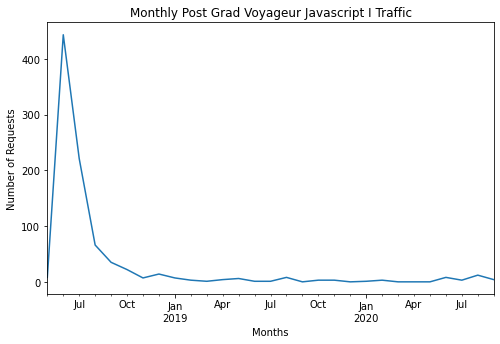

In [60]:
voyageurs = wd[wd.name == 'Voyageurs']

plt.figure(figsize=(8,5))
voyageurs[voyageurs.page_viewed == 'javascript-i'].page_viewed.resample('m').count().plot()
plt.title('Monthly Post Grad Voyageur Javascript I Traffic')
plt.xlabel('Months')
plt.ylabel('Number of Requests')

In [61]:
wd_grads[wd_grads.name == 'Voyageurs'].tail()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-10-02 09:21:00,mysql,186.0,24.0,66.69.66.113,Voyageurs,2018-05-29,2018-10-11,2.0,666966113.0
2020-10-02 09:21:08,mysql/clauses/where,186.0,24.0,66.69.66.113,Voyageurs,2018-05-29,2018-10-11,2.0,666966113.0
2020-10-02 09:21:21,mysql/tables,186.0,24.0,66.69.66.113,Voyageurs,2018-05-29,2018-10-11,2.0,666966113.0
2020-10-02 09:21:41,mysql/users,186.0,24.0,66.69.66.113,Voyageurs,2018-05-29,2018-10-11,2.0,666966113.0
2020-10-02 09:21:54,mysql/basic-statements,186.0,24.0,66.69.66.113,Voyageurs,2018-05-29,2018-10-11,2.0,666966113.0


In [62]:
ds_grads = df[df.end_date > '2019-06-16']
ds_grads = ds_grads[ds_grads.end_date < '2020-07-07']
ds_grads = ds_grads[ds_grads.program_id == 3.0]

In [63]:
ds_grads.head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470.0,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,971051958.0
2019-08-20 09:40:30,2-storytelling/bad-charts,467.0,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,971051958.0
2019-08-20 09:41:02,1-fundamentals/1.1-intro-to-data-science,469.0,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,971051958.0
2019-08-20 09:41:28,1-fundamentals/1.1-intro-to-data-science,480.0,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,971051958.0
2019-08-20 09:41:36,1-fundamentals/1.1-intro-to-data-science,482.0,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,971051958.0


In [64]:
ds_grads.tail()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-10-31 13:50:31,1-fundamentals/1.1-intro-to-data-science,485.0,34.0,173.174.142.84,Bayes,2019-08-19,2020-01-30,3.0,17317414284.0
2020-11-02 10:18:41,1-fundamentals/1.1-intro-to-data-science,485.0,34.0,173.174.142.84,Bayes,2019-08-19,2020-01-30,3.0,17317414284.0
2020-11-02 10:19:02,9-timeseries/2-acquire,485.0,34.0,173.174.142.84,Bayes,2019-08-19,2020-01-30,3.0,17317414284.0
2020-11-02 10:19:35,9-timeseries/5.1-modeling-lesson1,485.0,34.0,173.174.142.84,Bayes,2019-08-19,2020-01-30,3.0,17317414284.0
2020-11-02 11:57:55,timeseries/modeling-lesson1,485.0,34.0,173.174.142.84,Bayes,2019-08-19,2020-01-30,3.0,17317414284.0


In [65]:
ds_grads.groupby(ds_grads.name).page_viewed.value_counts().nlargest()

name   page_viewed                             
Bayes  1-fundamentals/1.1-intro-to-data-science    615
       6-regression/1-overview                     521
       10-anomaly-detection/1-overview             383
       6-regression/5.0-evaluate                   333
       5-stats/3-probability-distributions         320
Name: page_viewed, dtype: int64

In [66]:
bayes = ds_grads[ds_grads.index > '2020-01-30']
bayes.head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2020-01-30 08:01:31,1-fundamentals/1.1-intro-to-data-science,485.0,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,971051958.0
2020-01-31 11:05:13,1-fundamentals/1.1-intro-to-data-science,476.0,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,1365049145.0
2020-01-31 14:47:20,4-python/7.4.4-advanced-dataframes,476.0,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,1365049145.0
2020-01-31 14:47:26,3-sql/1-mysql-overview,476.0,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,1365049145.0
2020-01-31 14:47:27,3-sql/2-mysql-introduction,476.0,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,1365049145.0


Text(0, 0.5, 'Number of Requests')

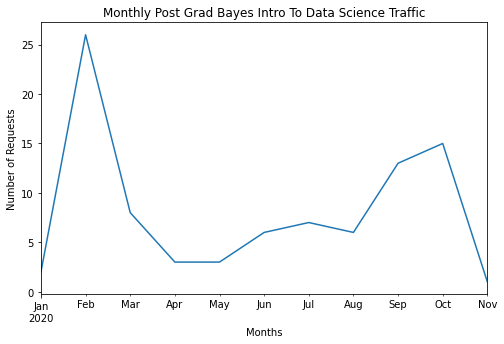

In [67]:
plt.figure(figsize=(8,5))
bayes[bayes.page_viewed == '1-fundamentals/1.1-intro-to-data-science'].page_viewed.resample('m').count().plot()
plt.title('Monthly Post Grad Bayes Intro To Data Science Traffic')
plt.xlabel('Months')
plt.ylabel('Number of Requests')

In [68]:
bayes.page_viewed.value_counts()

1-fundamentals/1.1-intro-to-data-science                   90
6-regression/1-overview                                    77
10-anomaly-detection/1-overview                            47
6-regression/7.0-model                                     39
3-sql/1-mysql-overview                                     39
12-distributed-ml/3-spark-api                              36
7-classification/3-prep                                    34
6-regression/5.0-evaluate                                  34
3-sql/3-databases                                          33
7-classification/4-explore                                 31
7-classification/6.1-logistic-regression                   30
7-classification/6.2-decision-trees                        30
6-regression/2.0-acquire-and-prep                          29
3-sql/2-mysql-introduction                                 29
3-sql/4-tables                                             29
5-stats/4.2-compare-means                                  28
11-nlp/3

### Conclusions

Web Dev:

- Based on the graduated cohorts that have had ample time to get a job and be secure in their job, it appears that Java I - III and MySQL are the subjects in the curriculum being accessed the most.

- I did find it odd that the cohorts that have been accessing the curriculum the most is Voyageours and Teddy

- Voyageurs graduated 2 years ago and this much activity was somewhat odd as it's been as recent as last month.

Data Science:

- Since Ada and Bayes are the only cohorts that have had ample time to get jobs and be established in their roles, I went ahead and assessed these cohorts further.

- Ada's data is missing altogether, but based on Bayes, it appears that intro to data science and regression have been accessed the most.

- We can assume the access to the intro to data science was just as a means to attempt to recruit new students, so regression is a place we can focus that students appear to need a refresher on.

- Anomaly detection is the second highest if we ignore the intro portion of the curriculum.

### Which lessons are least accessed?

In [69]:
#Creating a separate dataframe of cohorts with data
cohorts_with_data = df[df.start_date > '2018-01-01']

In [70]:
cohorts_with_data.head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,
2018-01-26 09:56:24,javascript-i/conditionals,2.0,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,971051961.0
2018-01-26 09:56:41,javascript-i/loops,2.0,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,971051961.0
2018-01-26 09:56:46,javascript-i/conditionals,3.0,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,971051961.0
2018-01-26 09:56:48,javascript-i/functions,3.0,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,971051961.0
2018-01-26 09:56:59,javascript-i/loops,2.0,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,971051961.0


In [71]:
# Creating 2 separate columns to more easily look at lessons
split_lesson = cohorts_with_data['page_viewed'].str.split("/", n = 1, expand = True) 
split_lesson["lesson"]= split_lesson[0] 
split_lesson["subject"]= split_lesson[1] 

In [72]:
split_lesson.drop(columns =[0,1], inplace = True)

In [73]:
split_lesson.head()

,lesson,subject
datetime,,
2018-01-26 09:56:24,javascript-i,conditionals
2018-01-26 09:56:41,javascript-i,loops
2018-01-26 09:56:46,javascript-i,conditionals
2018-01-26 09:56:48,javascript-i,functions
2018-01-26 09:56:59,javascript-i,loops


In [74]:
# merge it back to the previous dataframe
least_lesson = pd.concat([split_lesson, cohorts_with_data], axis = 1)

In [75]:
least_lesson.head()

,lesson,subject,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,conv_ip
datetime,,,,,,,,,,,
2018-01-26 09:56:24,javascript-i,conditionals,javascript-i/conditionals,2.0,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,971051961.0
2018-01-26 09:56:41,javascript-i,loops,javascript-i/loops,2.0,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,971051961.0
2018-01-26 09:56:46,javascript-i,conditionals,javascript-i/conditionals,3.0,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,971051961.0
2018-01-26 09:56:48,javascript-i,functions,javascript-i/functions,3.0,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,971051961.0
2018-01-26 09:56:59,javascript-i,loops,javascript-i/loops,2.0,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,971051961.0


In [76]:
least_lesson.groupby(least_lesson.name).lesson.value_counts().nsmallest()

name       lesson         
Andromeda  3-sql              1
           bonus-exercises    1
           capstone           1
           documentation      1
           events             1
Name: lesson, dtype: int64

In [77]:
least_lesson = least_lesson[least_lesson.name != 'Andromeda']

Text(0, 0.5, 'Number of Requests')

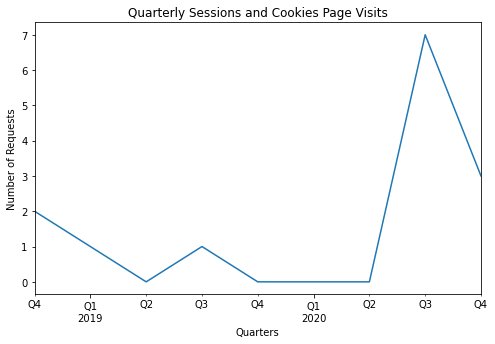

In [78]:
plt.figure(figsize=(8,5))
least_lesson[least_lesson.page_viewed == 'sessions-and-cookies'].page_viewed.resample('q').count().plot()
plt.title('Quarterly Sessions and Cookies Page Visits')
plt.xlabel('Quarters')
plt.ylabel('Number of Requests')

Text(0, 0.5, 'Number of Requests')

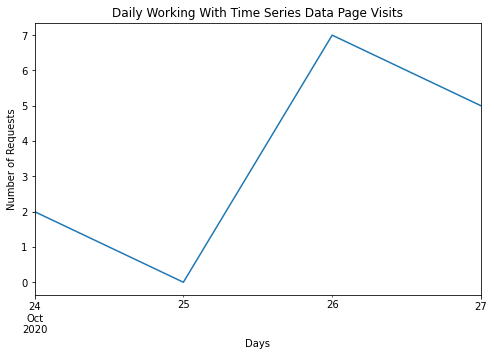

In [79]:
plt.figure(figsize=(8,5))
least_lesson[least_lesson.page_viewed == 'working-with-time-series-data'].page_viewed.resample('d').count().plot()
plt.title('Daily Working With Time Series Data Page Visits')
plt.xlabel('Days')
plt.ylabel('Number of Requests')

In [80]:
least_lesson.groupby(least_lesson.lesson).program_id.value_counts().nlargest(100)

lesson                            program_id
javascript-i                      2.0           76143
mysql                             2.0           57456
html-css                          2.0           56397
jquery                            2.0           39830
java-ii                           2.0           36767
java-iii                          2.0           36041
spring                            2.0           34411
java-i                            2.0           27780
javascript-ii                     2.0           26583
examples                          2.0            9155
3-sql                             3.0            6156
slides                            2.0            5863
4-python                          3.0            4828
6-regression                      3.0            4527
classification                    3.0            4097
1-fundamentals                    3.0            3793
5-stats                           3.0            3354
7-classification                  3.0

### Conclusions

- I chose to focus on the more lessons that were more reasonably lacking access and traffic by assessing only the values that are related to each cohort and reasonable for lack of access.

- It's not logical that only 1 person would access the curriculum so I focused on grouping the values by lessons and expanding the data on the program id.


Web Dev:

- The least accessed lesson in the curriculum for Web Dev was Sessions and Cookies.

- This may have been due to the subject itself may not have been as complex, but that is to be speculated as I am not familiar with web development.


Data Science:

- The least accessed lesson in the curriculum for Data Science was Working With Time Series.

- This may be due to the part of the curriculum where you are learning more so from the instructors due to it's difficulty rather than trying to learn it on your own.

# Final Thoughts

- This data presented some opportunities to possibly review any gaps in potential curriculum theft.
- There are several points where students are accessing the curriculum many years after they have left Codeup.
- This leaves the potential for someone to share the curriculum with others, share with another organization, or saved the curriculum for themselves.
- A better security protocol for accessing the curriculum may benefit Codeup in the future as they continue to grow and differentiate themselves from other schools.
- There are also many accesses from untracked ip's and we have no idea if it's an actual student or admin.
- It also appears that there are some lessons that are overlapped by instructor tutorials so the students aren't referring directly to the curriculum for any further development.
- The crossover between access of both programs appears to have still kept going, but we would need further review to see if the Baye's student became an instructor or staff member and is just accessing both as part of the benefit of being an employee.
- Overall, this data is very useful for anomaly detection and discovery to see if there are any trends going on in each cohort.